If not yet available some libraries and their python bindings have to be installed :<br>
- gmsh (best installed globally through package management system)
- python3 -m pip install pygmsh --user
- VTK (best installed globally through package management system)
- python3 -m pip install vtk --user

In [1]:
import numpy as np
from scipy import constants
from MeshedFields import *

# Create a meshed screen with a central hole

In [16]:
import pygmsh

Ra = 0.030
Ri = 0.002
lca = 0.005
lci = 0.0005
stretch = 5

geom = pygmsh.built_in.Geometry()
# we create the initial geometry as a streched ellipse to create
# different scaling lengths (cell sizes) along the different axes
p1 = geom.add_point([Ra*stretch, 0.0, 0.0], lcar=lca)
p2 = geom.add_point([0.0, Ra, 0.0], lcar=lca)
p3 = geom.add_point([-Ra*stretch, 0.0, 0.0], lcar=lca)
p4 = geom.add_point([0.0, -Ra, 0.0], lcar=lca)
p1i = geom.add_point([Ri*stretch, 0.0, 0.0], lcar=lci)
p2i = geom.add_point([0.0, Ri, 0.0], lcar=lci)
p3i = geom.add_point([-Ri*stretch, 0.0, 0.0], lcar=lci)
p4i = geom.add_point([0.0, -Ri, 0.0], lcar=lci)
pc = geom.add_point([0.0, 0.0, 0.0])
pa = geom.add_point([1.0, 0.0, 0.0])
# the mesh is circumscribed with four elliptic arcs
e1 = geom.add_ellipse_arc(start=p1, center=pc, point_on_major_axis=pa, end=p2)
e2 = geom.add_ellipse_arc(start=p2, center=pc, point_on_major_axis=pa, end=p3)
e3 = geom.add_ellipse_arc(start=p3, center=pc, point_on_major_axis=pa, end=p4)
e4 = geom.add_ellipse_arc(start=p4, center=pc, point_on_major_axis=pa, end=p1)
# the hole is circumscribed with four elliptic arcs
e1i = geom.add_ellipse_arc(start=p1i, center=pc, point_on_major_axis=pa, end=p2i)
e2i = geom.add_ellipse_arc(start=p2i, center=pc, point_on_major_axis=pa, end=p3i)
e3i = geom.add_ellipse_arc(start=p3i, center=pc, point_on_major_axis=pa, end=p4i)
e4i = geom.add_ellipse_arc(start=p4i, center=pc, point_on_major_axis=pa, end=p1i)
# these are combined into a line loop
hole = geom.add_line_loop([e1i,e2i,e3i,e4i])
outline = geom.add_line_loop([e1,e2,e3,e4])
geom.add_plane_surface(outline,holes=[hole])
# now we can create the mesh
mesh = pygmsh.generate_mesh(geom, dim=2, verbose=False)
# we squeeze the ellipse back to a circle
# angle it
# and move the screen to its intended position
d = np.array([0.0,0.0,1.0])
pts = [np.array([p[0]/stretch,p[1],p[0]/stretch])+d for p in mesh.points ]
tris = mesh.cells['triangle']
screen = MeshedField(pts,tris)

The screen is placed at z=1m from th origin. A beam is assumed to propagate in z direction<br>
The fields shall be reflected to th x direction. The screen normal is pointing in the negative z and positive x direction (x - left, y - up).

In [24]:
print("%d points" % len(screen.points))
print("%d triangles" % len(screen.triangles))
area = screen.MeshArea()
normals = screen.MeshNormals()
average = np.sum(normals, axis=0)/screen.Np
print("total mesh area = %7.3f cm²" % (1.0e4*np.sum(area)))
print("screen normal = %s" % average)
screen.ShowMeshedField(showAxes=True)

1736 points
3252 triangles
total mesh area =  39.773 cm²
screen normal = [  7.07106781e-01  -1.22246930e-15  -7.07106781e-01]


In [19]:
screen.ShowMeshedField()

### define the timing
The beam is assumed to start at t=0. The fields are propagating with c so the expected time a
signal arrives at some screen point is z/c.

In [25]:
# time step
screen.dt = 1.0e-13
# all points use the same timing grid
screen.Nt = 400
screen.t0 = np.array([p[2]/constants.c-screen.Nt/2*screen.dt for p in screen.pos])

### Write the file
It is assumed that the script was started from the scripts directory. The file should be created in the tests folder.

In [26]:
filename="../tests/DiffractionScreen.h5"
screen.WriteMeshedField(filename)

### Check the file after running the test

In [10]:
filename = "../tests/DiffractionScreenWithFields.h5"
computed = MeshedField.ReadMeshedField(filename)

print("%d points" % len(computed.points))
print("%d triangles" % len(computed.triangles))
area = computed.MeshArea()
normals = computed.MeshNormals()
average = np.sum(normals, axis=0)/computed.Np
print("total mesh area = %7.3f cm²" % (1.0e4*np.sum(area)))
print("screen normal = %s" % average)

corner points :  (1736, 3)
triangles :  (3252, 3)
Nt = 400   dt = 1e-13 
t0 :  (3252,)
field :  (3252, 400, 6)
1736 points
3252 triangles
total mesh area =  39.773 cm²
screen normal = [  7.07106781e-01  -1.22246930e-15  -7.07106781e-01]


In [11]:
area = computed.MeshArea()
S = [np.linalg.norm(computed.EnergyFlowVector(i)) for i in range(computed.Np)]
Pz = [computed.NormalEnergyFlow(i) for i in range(computed.Np)]

print("peak energy density = %.6f J/m²" % np.max(S))
print("total pulse energy = %.1f µJ" % (1e6*np.dot(area,Pz)))

peak energy density = 0.020378 J/m²
total pulse energy = 0.5 µJ


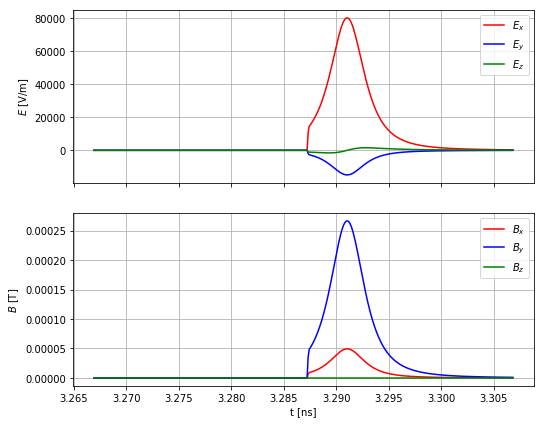

In [16]:
computed.ShowMeshedField(scalars=Pz,scalarTitle="Pz",highlight=[987],showGrid=False)
computed.ShowFieldTrace(987)

cell No. 1891 pos=[ -2.00271196e-03  -2.68782555e-04   9.97997288e-01]
pointing vector S=[ -1.26113503e-08  -1.69256039e-09   2.02864616e-02]


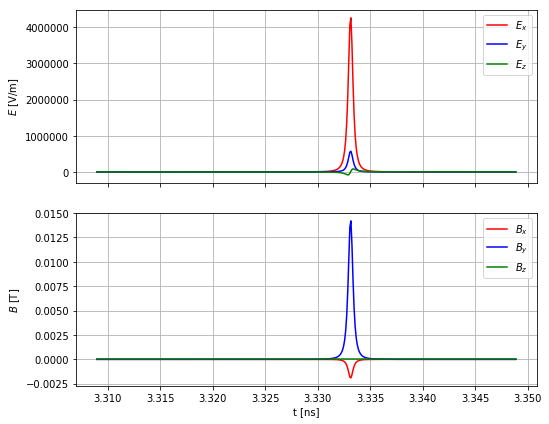

cell No. 2818 pos=[  2.00060523e-03  -2.61396365e-04   1.00200061e+00]
pointing vector S=[  1.24713392e-08  -1.62948827e-09   2.03784352e-02]


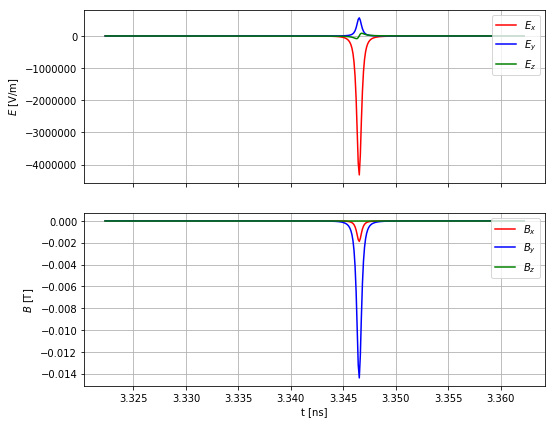

In [15]:
def pick(id):
    if id>0 and id<computed.Np:
        print("cell No. %d pos=%s" % (id,computed.pos[id]))
        print("pointing vector S=%s" % computed.EnergyFlowVector(id))
        computed.ShowFieldTrace(id)

computed.ShowMeshedField(scalars=Pz,scalarTitle="Pz",pickAction=pick,showGrid=False)

In [21]:
t = 3.34e-9
fields = computed.FieldsAtTime(t)
Ex = [f[0] for f in fields]
Ey = [f[1] for f in fields]
computed.ShowMeshedField(scalars=Ey,scalarTitle="Ey",showGrid=False,lut=phaseLUT())